# Load packages

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import random

from os import path
from tensorflow.keras.utils import image_dataset_from_directory
from matplotlib import pyplot as plt
from tensorflow.keras import layers, losses, optimizers, metrics, callbacks, Model, Input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [2]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [3]:
tf.__version__

'2.10.1'

In [4]:
SEED = 123
N_CLASS = 10
IMG_SIZE = 32

# Load data

In [5]:
train_labels_df = pd.read_csv(path.join(os.getcwd(), 'train_val_test', 'train.csv')).drop(["Unnamed: 0"], axis=1)
train_labels_df

,name,codes
0,1.png,6
1,100.png,1
2,10001.png,1
3,10002.png,6
4,10003.png,6
...,...,...
34995,9994.png,1
34996,9996.png,3
34997,9997.png,9
34998,9998.png,1


In [6]:
dataset_train = image_dataset_from_directory(
    directory=path.join(os.getcwd(), 'train_val_test', 'train'),
    labels=list(train_labels_df['codes']),
    label_mode='int',
    validation_split=0,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=512,
    seed=SEED
)
dataset_train = dataset_train.map(lambda x, y : (x, tf.one_hot(y, N_CLASS)))

Found 35000 files belonging to 1 classes.


In [7]:
val_labels_df = pd.read_csv(path.join(os.getcwd(), 'train_val_test', 'val.csv')).drop(["Unnamed: 0"], axis=1)
val_labels_df

,name,codes
0,10.png,3
1,1000.png,5
2,10000.png,5
3,10014.png,6
4,10029.png,7
...,...,...
4995,9961.png,8
4996,9977.png,3
4997,998.png,1
4998,9986.png,0


In [8]:
dataset_val = image_dataset_from_directory(
    directory=path.join(os.getcwd(), 'train_val_test', 'val'),
    labels=list(val_labels_df['codes']),
    label_mode='int',
    validation_split=0,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=512,
    seed=SEED
)
dataset_val = dataset_val.map(lambda x, y: (x, tf.one_hot(y, N_CLASS)))

Found 5000 files belonging to 1 classes.


In [9]:
test_labels_df = pd.read_csv(path.join(os.getcwd(), 'train_val_test', 'test.csv')).drop(["Unnamed: 0"], axis=1)

dataset_test = image_dataset_from_directory(
    directory=path.join(os.getcwd(), 'train_val_test', 'test'),
    labels=list(test_labels_df['codes']),
    label_mode='int',
    validation_split=0,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=512,
    seed=SEED
)
dataset_test = dataset_test.map(lambda x, y: (x, tf.one_hot(y, N_CLASS)))

Found 10000 files belonging to 1 classes.


In [10]:
X, y = next(iter(dataset_train))
X.shape, y.shape

(TensorShape([512, 32, 32, 3]), TensorShape([512, 10]))

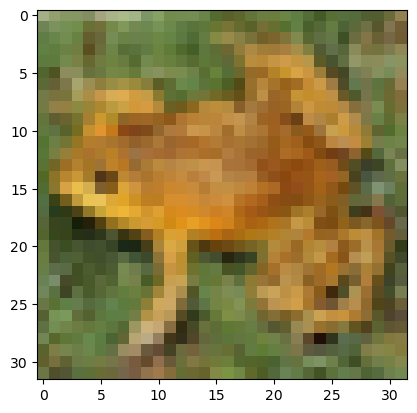

In [11]:
plt.imshow(X[3].numpy().astype(int))

In [12]:
y[3]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)>

# FCN - initialization

In [13]:
os.makedirs("weights", exist_ok=True)

In [14]:
def create_model():
    input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = layers.Flatten()(input_layer)
    x = layers.Dense(4096, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(4096, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(2048, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    output = layers.Dense(10, activation="softmax")(x)
    model = Model(inputs=input_layer, outputs=output)
    return model

model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 4096)              12587008  
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 batch_normalization_1 (Batc  (None, 4096)             16384     
 hNormalization)                                             

In [15]:
dataset_train = dataset_train.map(lambda x, y : (preprocess_input(x), y))
dataset_val = dataset_val.map(lambda x, y : (preprocess_input(x), y))

In [16]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.CategoricalCrossentropy(),
    metrics=[metrics.CategoricalAccuracy(), metrics.CategoricalCrossentropy()]
)
checkpoint = callbacks.ModelCheckpoint(
    filepath="fully_connected.h5",
    monitor="val_categorical_accuracy",
    verbose=0,
    save_best_only=True,
    save_weights_only=True
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_categorical_accuracy',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, min_lr=0.00001, verbose=1)

In [17]:
history = model.fit(
    dataset_train,
    epochs=200,
    validation_data=dataset_val,
    shuffle=True,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/200
69/69 [==============================] - 10s 55ms/step - loss: 2.2314 - categorical_accuracy: 0.3451 - categorical_crossentropy: 2.2314 - val_loss: 2.9581 - val_categorical_accuracy: 0.3666 - val_categorical_crossentropy: 2.9581 - lr: 0.0010
Epoch 2/200
69/69 [==============================] - 8s 101ms/step - loss: 1.5559 - categorical_accuracy: 0.4465 - categorical_crossentropy: 1.5559 - val_loss: 1.7126 - val_categorical_accuracy: 0.4446 - val_categorical_crossentropy: 1.7126 - lr: 0.0010
Epoch 3/200
69/69 [==============================] - 8s 101ms/step - loss: 1.4153 - categorical_accuracy: 0.4968 - categorical_crossentropy: 1.4153 - val_loss: 1.5722 - val_categorical_accuracy: 0.4548 - val_categorical_crossentropy: 1.5722 - lr: 0.0010
Epoch 4/200
69/69 [==============================] - 8s 108ms/step - loss: 1.3008 - categorical_accuracy: 0.5359 - categorical_crossentropy: 1.3008 - val_loss: 1.5824 - val_categorical_accuracy: 0.4664 - val_categorical_crossentropy: 1.58

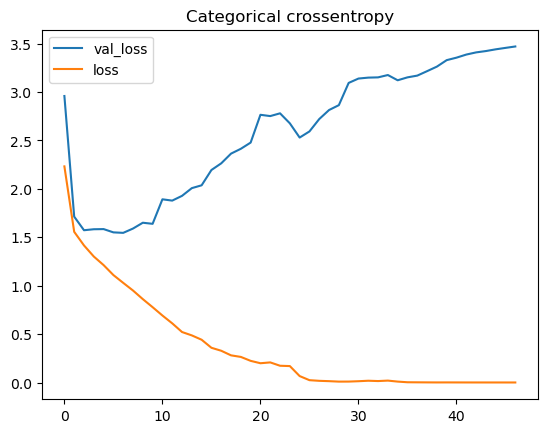

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
plt.figure()
plt.plot(history.epoch, val_loss, label="val_loss")
plt.plot(history.epoch, loss, label="loss")
plt.legend()
plt.title("Categorical crossentropy")
plt.show()

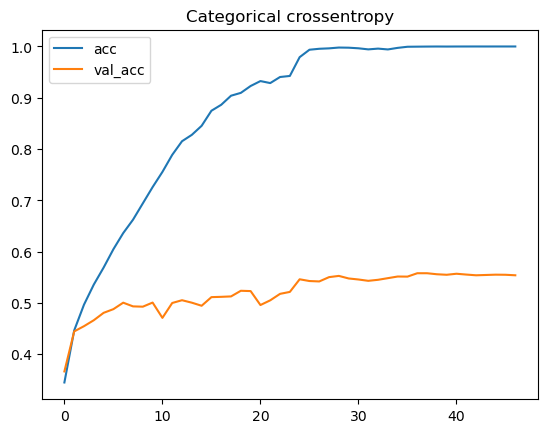

In [19]:
plt.figure()
plt.plot(history.epoch, acc, label="acc")
plt.plot(history.epoch, val_acc, label="val_acc")
plt.legend()
plt.title("Categorical crossentropy")
plt.show()

## Experiments

Training will be repeated 10 times with different weights initialization.

In [20]:
TRAINING_SEEDS = list(range(10))
results = []
for seed in TRAINING_SEEDS:
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model = create_model()

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss=losses.CategoricalCrossentropy(),
        metrics=[metrics.CategoricalAccuracy(), metrics.CategoricalCrossentropy()]
    )

    history = model.fit(
        dataset_train,
        epochs=200,
        validation_data=dataset_val,
        shuffle=True,
        callbacks=[early_stopping, reduce_lr]
    )
    eval_results = model.evaluate(dataset_test)

    results += [{
        'seed': seed,
        'results': dict(zip(model.metrics_names, eval_results))
    }]

results = pd.DataFrame(results)
results = pd.concat([results.drop(["results"], axis=1), results["results"].apply(pd.Series)], axis=1)
results.to_csv('fully_connected_results.csv')

Epoch 1/200
69/69 [==============================] - 10s 117ms/step - loss: 2.1945 - categorical_accuracy: 0.3459 - categorical_crossentropy: 2.1945 - val_loss: 3.0274 - val_categorical_accuracy: 0.3354 - val_categorical_crossentropy: 3.0274 - lr: 0.0010
Epoch 2/200
69/69 [==============================] - 9s 119ms/step - loss: 1.5435 - categorical_accuracy: 0.4477 - categorical_crossentropy: 1.5435 - val_loss: 1.7909 - val_categorical_accuracy: 0.4254 - val_categorical_crossentropy: 1.7909 - lr: 0.0010
Epoch 3/200
69/69 [==============================] - 9s 111ms/step - loss: 1.4084 - categorical_accuracy: 0.4971 - categorical_crossentropy: 1.4084 - val_loss: 1.6493 - val_categorical_accuracy: 0.4618 - val_categorical_crossentropy: 1.6493 - lr: 0.0010
Epoch 4/200
69/69 [==============================] - 9s 117ms/step - loss: 1.2986 - categorical_accuracy: 0.5361 - categorical_crossentropy: 1.2986 - val_loss: 1.5343 - val_categorical_accuracy: 0.4696 - val_categorical_crossentropy: 1.5

In [21]:
results

,seed,loss,categorical_accuracy,categorical_crossentropy
0,0,10.763290,0.1896,10.763290
1,1,9.208529,0.2011,9.208529
2,2,10.146886,0.1875,10.146886
3,3,9.810303,0.1980,9.810303
4,4,8.650546,0.1910,8.650546
5,5,10.603573,0.1762,10.603573
6,6,10.594611,0.2039,10.594611
7,7,11.039579,0.2010,11.039579
8,8,8.886784,0.1928,8.886784
9,9,6.620886,0.1951,6.620886
